In [1]:
%matplotlib inline
%run ./lorenz_system.py
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib import cm
import numpy as np
import urllib2
import random
import math

In [2]:
stepCnt = 2500

In [3]:
xs,ys,zs = build_system(stepCnt)

# Lorenz System

$$
\dfrac{dx}{dt} = \sigma(y-x), \dfrac{dy}{dt} = x(\rho -z) - y, \dfrac{dz}{dt} = xy-\beta z
$$

# Baseline Plots

## 3d Plot

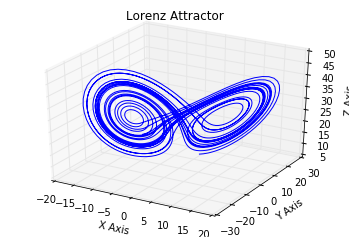

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

## 2d Plots

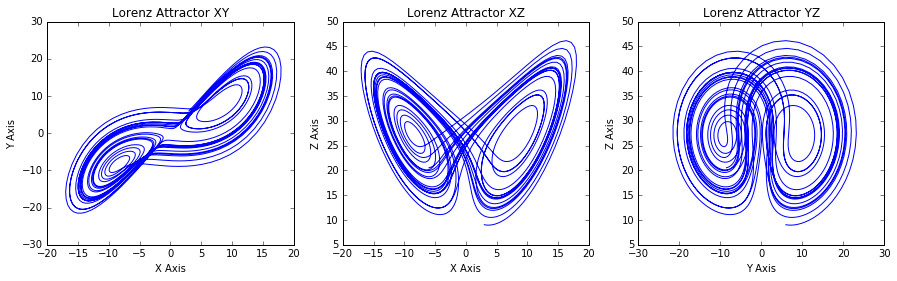

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figwidth(15)
ax1.plot(xs, ys)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_title("Lorenz Attractor XY")

ax2.plot(xs, zs)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor XZ")

ax3.plot(ys, zs)
ax3.set_xlabel("Y Axis")
ax3.set_ylabel("Z Axis")
ax3.set_title("Lorenz Attractor YZ")

# Lorenz Attractor Centers

## Derivation

$$
Q = (\pm \sqrt{b(r-1)}, \pm \sqrt{b(r-1)}, r-1 )
$$

In [6]:
def get_yz_centers(b,r,one=False):
    x = math.sqrt(const_b*(const_r - 1))
    y = math.sqrt(const_b*(const_r - 1))
    z = r - 1
    
    if one:
        return y,z
    else:
        return (y,-y), (z,z)

## Plot

In [7]:
y_center, z_center = get_yz_centers(const_b, const_r)
one_x,one_y,one_z = build_system(stepCnt,s=2)

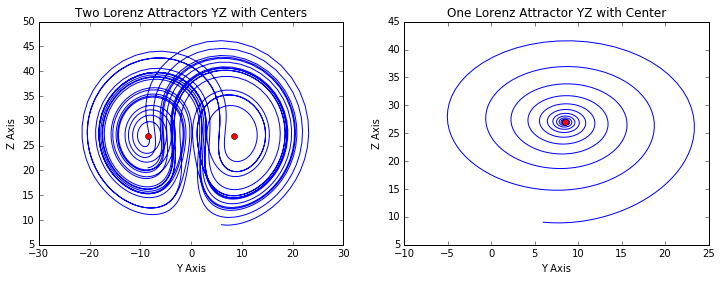

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figwidth(12)

ax1.plot(ys, zs)
ax1.plot(y_center,z_center,'ro')
ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Two Lorenz Attractors YZ with Centers")

ax2.plot(one_y, one_z)
ax2.plot(y_center[0],z_center[0],'ro')
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("One Lorenz Attractor YZ with Center")

plt.show()

## Results

One center requires use of positive y and z.

Two centers requires use of both positive and negative y and positive z to match both.

# Point Density

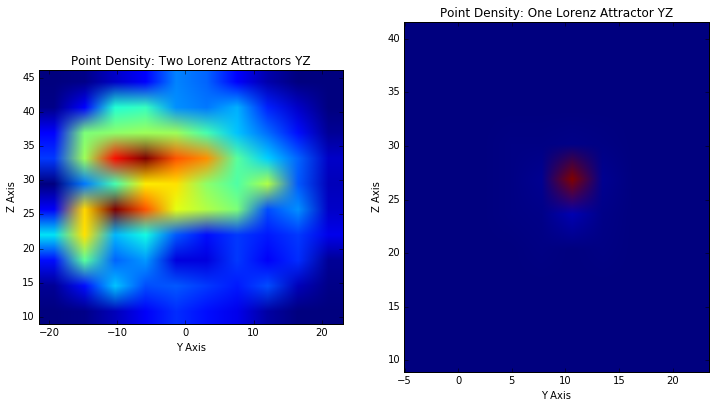

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figwidth(12)
f.set_figheight(10)

# two centers
heatmap, xedges, yedges = np.histogram2d(ys, zs)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent)
ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Point Density: Two Lorenz Attractors YZ")

# one center
heatmap, xedges, yedges = np.histogram2d(one_y, one_z)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax2.imshow(heatmap, extent=extent)
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Point Density: One Lorenz Attractor YZ")

# Isobar Grouping

$$
dist = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [10]:
def dist(p1, p2):
    '''
    return distance between two coordinates
    
    Parameters:
        p1 - xy coordinates
        p2 - xy coordinates
        
    Return:
        float - distnace between p1 and p2
    '''
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [11]:
def sparse_system(coords, step_cnt=10):
    '''
    Given make it sparser by only taking so many indexes
    '''
    return coords[0::step_cnt]

In [12]:
def format_cluster_points(x_axis, y_axis, center):
    '''
    format cluster points with the distance to the center included
    
    Parameters:
        x_axis     - array containing coordinate adjace to y_axis
        y_axis     - array containing coordinate adjace to x_axis
        center_one - coordiantes for Lorenz Attractor one\
    
    Return:
        attractor_one_points - array for Lorenz Attractor one with
                               a calculated distnace
    '''
    attractor_points  = []
    
    for i in range(len(x_axis)):
        point = (x_axis[i], y_axis[i])
        distance = dist(point, center)
        
        point = {
            'coord': point,
            'dist': distance
        }
        attractor_points.append(point)
        
    return attractor_points

In [13]:
def cluster_low_hi_points(x_axis, y_axis, center_one, center_two):
    '''
    format points by distance closest to center one or two. Include
    distance in new arrays that are returned
    
    Parameters:
        x_axis     - array containing coordinate adjace to y_axis
        y_axis     - array containing coordinate adjace to x_axis
        center_one - coordiantes for Lorenz Attractor one
        center_two - coordinates for Lorenz Attractor two
    
    Return:
        attractor_one_points - array for Lorenz Attractor one with
                               a calculated distnace
        attractor_two_points - array for Lorenz Attractor two with
                               a calculated distance
    '''
    attractor_one_points  = []
    attractor_two_points  = []
    
    for i in range(len(x_axis)):
        point = (x_axis[i], y_axis[i])
        cent_one_dist = dist(point, center_one)
        cent_two_dist = dist(point, center_two)
        
        if cent_one_dist < cent_two_dist:
            point = {
                'coord': point,
                'dist': cent_one_dist
            }
            attractor_one_points.append(point)
        else:
            point = {
                'coord': point,
                'dist': cent_two_dist
            }
            attractor_two_points.append(point)
    
    return attractor_one_points, attractor_two_points

Standard Deviation Formula:
$$
\sigma = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

In [14]:
def compute_attractor_distance_standard_deviation(attractor):
    '''
    compute the standard deviation of the distance of the points to 
    the attractor
    
    Paramaters:
        attractor - one of the return results computed in funciton 
                    cluster_low_hi_points
                    
    Return:
        float - standard deviation
    '''
    # calculate the mean
    mean = 0
    for i in range(len(attractor)):
        mean += attractor[i]['dist']
    mean /= len(attractor)
    
    # Perform summation
    summation = 0
    for i in range(len(attractor)):
        summation += (attractor[i]['dist'] - mean)**2
        
    # divide summation by N
    summation /= len(attractor)
    
    # return square root
    return math.sqrt(summation)

$$
\sigma x = dist \\
x = \dfrac{dist}{\sigma}
$$

In [15]:
def cluster_attractor_groups(attractor, attractor_std):
    '''
    cluster points together by standard deviation using above formula
    to calculate the index for the array
    
    Parameters:
        attractor        - array of points attracted
        attractor_std    - standard devation of points attracted
        
    Return:
        attractor_groups - matrix with groups by index of closest to furthest
    '''
    attractor_groups = []
    
    for point in attractor:
        std_index = int(point['dist'] / attractor_std)

        # check if array needs to be extended
        if len(attractor_groups) - 1 < std_index:
            attractor_groups.extend([{'min': sys.maxint, 
                                      'max': -1,
                                      'data': []
                                     } for i in range(std_index + 1 - len(attractor_groups))])
        
        # Check min and max of index
        if point['dist'] < attractor_groups[std_index]['min']:
            # assign min
            attractor_groups[std_index]['min'] = point['dist']
        if point['dist'] > attractor_groups[std_index]['max']:
            # assign max
            attractor_groups[std_index]['max'] = point['dist']
        
        # add point to array
        attractor_groups[std_index]['data'].append(point)
    
    return attractor_groups

In [16]:
def format_attractor_groups_plot(attractor):
    '''
    turn an attactor group into a plottable format
    
    Parameters:
        attractor - attractor group created in cluster_attractor_groups
        
    Return:
        x         - array of x points to plot
        y         - array of y points to plot
    '''
    x = []
    y = []
    
    for i in range(len(attractor)):
        x.append([])
        y.append([])
        
        for j in range(len(attractor[i]['data'])):
            x[i].append(attractor[i]['data'][j]['coord'][0])
            y[i].append(attractor[i]['data'][j]['coord'][1])
    
    return x,y

In [17]:
def convert_groups_low_hi(attractor_group_one, attractor_group_two, center_one, center_two):
    '''
    count the total size of the groups to decide which is low and which 
    is high pressure.
    
    Parameters:
        attractor_group_one - matrix built by cluster_attractor_groups
        attractor_group_two - matrix built by cluster_attractor_groups
        
    Return:
        low  - highest count attractor group
        high - lowest count attractor group
    '''
    one = 0
    two = 0
    for i in range(len(attractor_group_one)):
        one += len(attractor_group_one[i])
    for i in range(len(attractor_group_two)):
        two += len(attractor_group_two[i])
        
    if one > two:
        return center_one, attractor_group_one, center_two, attractor_group_two
    return center_two, attractor_group_two, center_one, attractor_group_one

In [18]:
def plot_centers(ax, low_press, center_y, center_z):
    if dist(low_press[1]['data'][1]['coord'], (center_y[0],center_z[0])):
        ax.text(center_y[0], center_z[0], 'H',
                 verticalalignment='center', horizontalalignment='center',
                 color='red', fontsize=30)
        ax.text(center_y[1], center_z[1], 'L',
                 verticalalignment='center', horizontalalignment='center',
                 color='blue', fontsize=30)
    else:
        ax.text(center_y[1], center_z[1], 'H',
                 verticalalignment='center', horizontalalignment='center',
                 color='red', fontsize=30)
        ax.text(center_y[0], center_z[0], 'L',
                 verticalalignment='center', horizontalalignment='center',
                 color='blue', fontsize=30)

## Two Centers

In [19]:
xs_two,ys_two,zs_two          = build_system(stepCnt, s=10)
y_two                         = sparse_system(ys_two)
z_two                         = sparse_system(zs_two)
y_two_center, z_two_center    = get_yz_centers(const_b, const_r)

In [20]:
center_one                   = (y_two_center[0], z_two_center[0])
center_two                   = (y_two_center[1], z_two_center[1])
attractor_one, attractor_two = cluster_low_hi_points(y_two,\
                                                     z_two,\
                                                     center_one,\
                                                     center_two)

In [21]:
attractor_one_std = compute_attractor_distance_standard_deviation(attractor_one)
attractor_two_std = compute_attractor_distance_standard_deviation(attractor_two)

In [22]:
attractor_one_groups = cluster_attractor_groups(attractor_one, 4)
attractor_two_groups = cluster_attractor_groups(attractor_two, 4)

In [23]:
low_center, low_pressure_group, high_center, high_pressure_group = convert_groups_low_hi(attractor_one_groups,\
                                                                                         attractor_two_groups,\
                                                                                         center_one,\
                                                                                         center_two)

In [24]:
low_x, low_y   = format_attractor_groups_plot(low_pressure_group)
high_x, high_y = format_attractor_groups_plot(high_pressure_group)

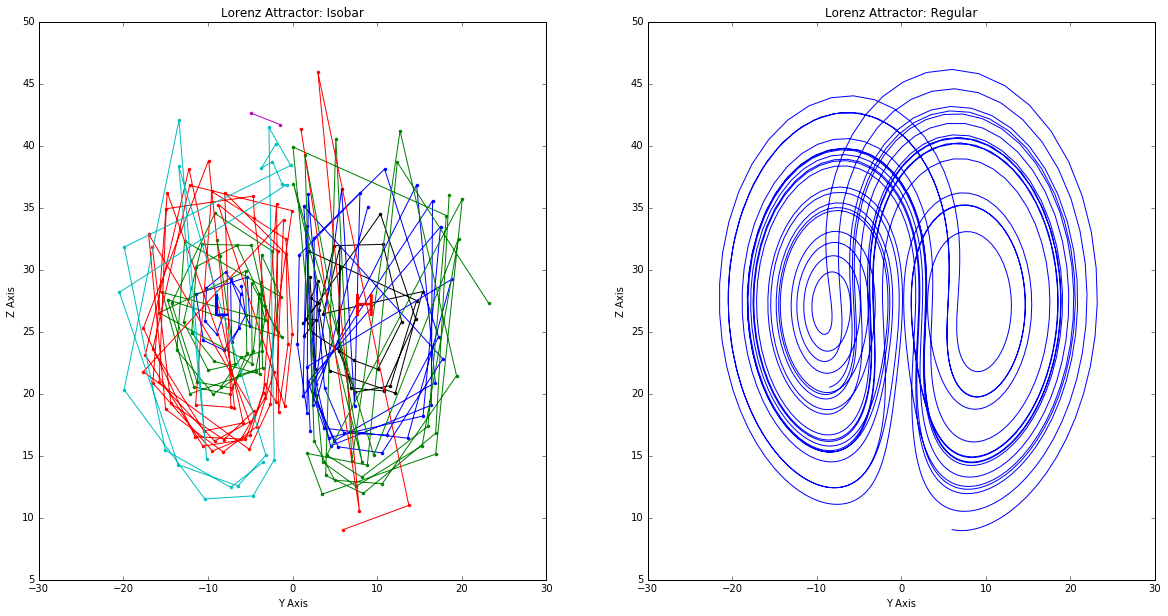

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(20)

for i in range(len(low_x)):
    if len(low_x[i]) > 0:
        ax1.plot(low_x[i], low_y[i],'.-')
        
for i in range(len(high_x)):
    if len(high_x[i]) > 0:
        ax1.plot(high_x[i], high_y[i],'.-')

# Graph Centers
plot_centers(ax1, low_pressure_group, y_two_center, z_two_center)

ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Lorenz Attractor: Isobar")

ax2.plot(ys_two,zs_two)
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor: Regular")

plt.show()

## One Center

In [26]:
xs,ys,zs           = build_system(stepCnt, s=2)
x                  = sparse_system(ys)
y                  = sparse_system(zs)
y_center, z_center = get_yz_centers(const_b, const_r)
one_center         = (y_center, z_center)

In [27]:
attractor = format_cluster_points(x,y,(y_center[0], z_center[0]))

In [28]:
attractor_std = compute_attractor_distance_standard_deviation(attractor)

In [29]:
attractor_groups = cluster_attractor_groups(attractor, attractor_std)

In [30]:
a_x, a_y = format_attractor_groups_plot(attractor_groups)

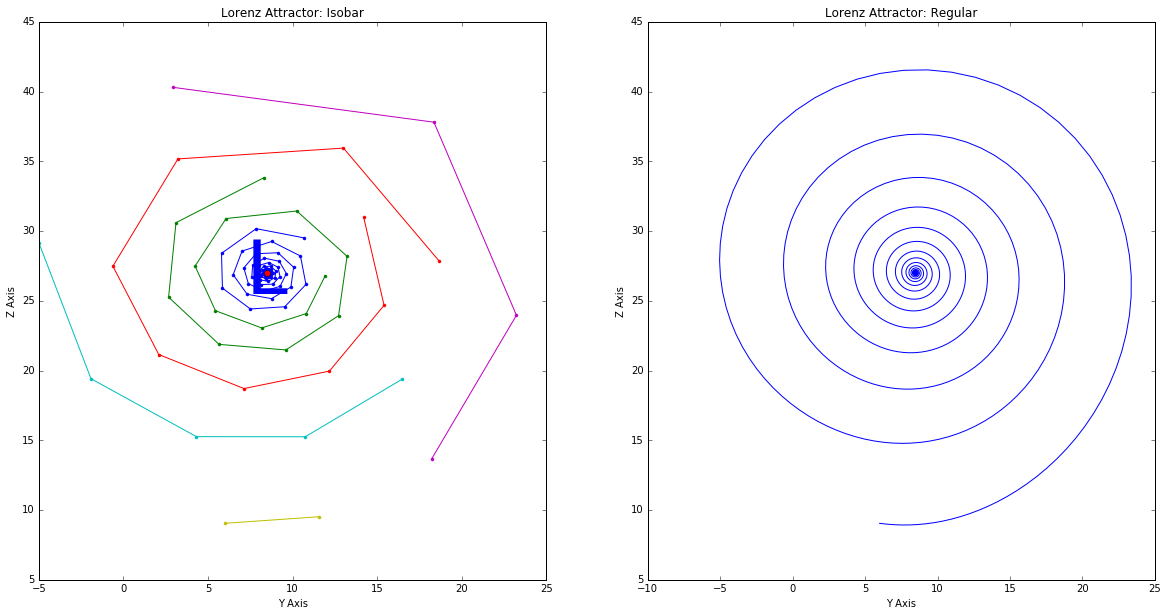

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2)

f.set_figheight(10)
f.set_figwidth(20)

for i in range(len(a_x)):
    if len(a_x[i]) > 0:
        ax1.plot(a_x[i], a_y[i],'.-')
        
# Graph Center
ax1.plot(y_center[0],z_center[0],'ro')
ax1.text(y_center[0], z_center[0], 'L',
         verticalalignment='center', horizontalalignment='center',
         color='blue', fontsize=75)


ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Lorenz Attractor: Isobar")


ax2.plot(ys, zs)
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor: Regular")

plt.show()

# Pressure

In [32]:
# Values found at: http://www.theweatherprediction.com/habyhints2/410/
sea_level_pressure_high_max  = 1086 # highest ever recorded
sea_level_pressure_high_min  = 1000 # average pressure
sea_level_pressure_low_max   = 1000 # standard rain storm
sea_level_pressure_low_min   = 980  # category 1 hurricane
sea_level_pressure_hurricane = 870  # lowest ever recorded hurricane, besdies tornado

In [33]:
def build_pressure_system(attractor_system, minimum, maximum, isHigh=False):
    '''
    Assign pressure to each point in system based on grouping
    
    Parameters:
        attractor_system - system built by convert_groups_low_hi
        minimum          - minimum value for pressure
        maximum          - maximum value for pressure
    '''
    multiplier = 1
    
    # generate random number in range that is multiple of 4
    pressure = random.randrange(minimum, maximum,4)
    
    if isHigh == True:
        multiplier = -1
        pressure += 4 * (len(attractor_system) - 1)
        
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            # assign pressure
            if attractor_system[i]['data'][j]['dist'] < 4*i:
                attractor_system[i]['data'][j]['pressure'] = pressure + attractor_system[i]['data'][j]['dist']
            else:
                attractor_system[i]['data'][j]['pressure'] = pressure + attractor_system[i]['data'][j]['dist'] - 4*i
            
        pressure = pressure + 4*multiplier

In [34]:
def format_value_plot(pressure_system, key):
    '''
    turn an pressure group into a plottable format
    
    Parameters:
        pressure_system - pressure system created in build_pressure_system
        key             - key to access dictionary value
        
    Return:
        x               - array of x points to plot
        y               - array of y points to plot
        value           - value of keys
    '''
    x = []
    y = []
    values = []
    
    for i in range(len(pressure_system)):
        for j in range(len(pressure_system[i]['data'])):
            x.append(pressure_system[i]['data'][j]['coord'][0])
            y.append(pressure_system[i]['data'][j]['coord'][1])
            values.append(pressure_system[i]['data'][j][key])
    
    return x,y,values

## Graphing Two Center Pressure System

In [35]:
build_pressure_system(low_pressure_group, sea_level_pressure_low_min, sea_level_pressure_low_max)
build_pressure_system(high_pressure_group, sea_level_pressure_high_min, sea_level_pressure_high_max, isHigh=True)
build_pressure_system(attractor_groups, sea_level_pressure_hurricane, sea_level_pressure_low_min)

In [36]:
low_x, low_y, low_pressure    = format_value_plot(low_pressure_group, 'pressure')
high_x, high_y, high_pressure = format_value_plot(high_pressure_group, 'pressure')

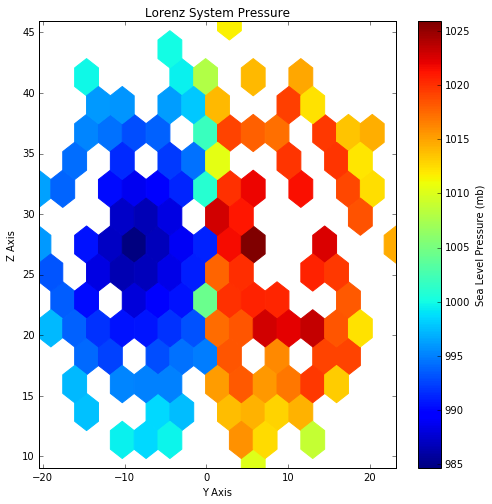

In [37]:
fig = plt.figure()
ax = fig.gca()

fig.set_figwidth(8)
fig.set_figheight(8)

gridsize=30
plt.hexbin(low_x + high_x, (low_y + high_y), C=low_pressure + high_pressure, gridsize=15, cmap=cm.jet, bins=None)
plt.axis([min(low_x + high_x), max(low_x + high_x), min(low_y + high_y), max(low_y + high_y)])

ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz System Pressure")

cb = plt.colorbar()
cb.set_label('Sea Level Pressure (mb)')
plt.show()   

# Temperature

Convert Kelvin to Celcius

$$
T(°C) = KELVIN - 273.15
$$

In [38]:
def kelvin_to_celcius(kelvin_temp):
    '''
    convert kelvin to celcius
    
    Parameters:
        kelvin_temp - temperature in kelvin
        
    Return:
        float - conversion to celcius value
    '''
    return kelvin_temp - 273.15

$$
T = \dfrac{P_v}{R}
$$
```
P - pressure
T - absolute value of temperature
R - density constant
```


In [39]:
air_density_constant = 3.4

def add_temperature(attractor_system):
    '''
    add temperature column to system
    
    Parameters:
        attractor_system - pressure system created in build_pressure_system
    '''
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            temp = attractor_system[i]['data'][j]['pressure'] / air_density_constant
            attractor_system[i]['data'][j]['temp'] = kelvin_to_celcius(temp)

In [40]:
add_temperature(low_pressure_group)
add_temperature(high_pressure_group)
add_temperature(attractor_groups)

In [41]:
low_x, low_y, low_temp    = format_value_plot(low_pressure_group, 'temp')
high_x, high_y, high_temp = format_value_plot(high_pressure_group, 'temp')
one_x, one_y, one_temp = format_value_plot(attractor_groups, 'temp')

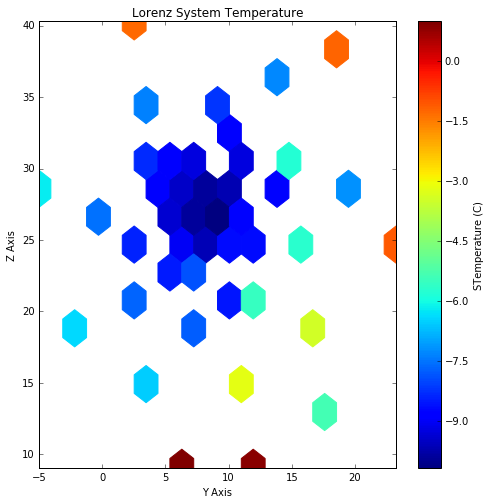

In [42]:
fig = plt.figure()
ax = fig.gca()

fig.set_figwidth(8)
fig.set_figheight(8)

gridsize=30
plt.hexbin(one_x, one_y, C=one_temp, gridsize=15, cmap=cm.jet, bins=None)
plt.axis([min(one_x), max(one_x), min(one_y), max(one_y)])

ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz System Temperature")

cb = plt.colorbar()
cb.set_label('STemperature (C)')
plt.show()   

# Wind Speed

This portion is particularly difficult as most methods of wind speed calculation require [Wind Profile Power Law](https://en.wikipedia.org/wiki/Wind_profile_power_law) which uses the speed of wind at a different altitude to calculate the speed at the current alittude. We don't have either of these so instead we need to find another way to do it. 

Luckily [Weather Underground](https://www.wunderground.com/) provides free [data](https://www.wunderground.com/history/airport/KPHL/2015/10/11/CustomHistory.html?dayend=11&monthend=10&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1) that we can access and use. We are going to use linear and polynomial regression in attempt to find the best line to fit to the data.

In [43]:
def inch_to_mb(inches):
    '''
    convert inches to millibars
    
    Parameters:
        inches - float to convert
    
    Return:
        - conversion
    '''
    return (1013.25*inches) / 29.92

## Format Data From Weather Underground

In [44]:
mean_pressure_index   = 11
mean_wind_speed_index = 17
page_link             = 'https://www.wunderground.com/history/airport/' + \
                        'KMIA/2015/10/11/CustomHistory.html?dayend=11&' + \
                        'monthend=10&yearend=2016&req_city=&req_state=' + \
                        '&req_statename=&reqdb.zip=&reqdb.magic=&reqdb' + \
                        '.wmo=&format=1'

In [45]:
response = urllib2.urlopen(page_link)
html = response.read()

In [46]:
rows                = [row.split(',') for row in html.split('<br />')[1:-1]]
pressure_wind_speed = [[float(row[mean_pressure_index]), float(row[mean_wind_speed_index])] for row in rows]

In [47]:
a = np.array([inch_to_mb(row[0]) for row in pressure_wind_speed])
b = np.array([row[1] for row in pressure_wind_speed])

The data is pretty good, but we are lacking information for the extreme ends. Therefore, we will use some manual data entry to augment the data to get better results. 

The low pressure extreme is taken from: https://www.scientificamerican.com/article/earths-strongest-most-massive-storm-ever/

The high pressure extreme is taken from: https://www.wunderground.com/blog/weatherhistorian/world-and-us-anticyclonic-high-barometric-pressure-records

In [48]:
add_a = []
add_b = []

for i in range(0,10):
    add_a.append(870.0)
    add_a.append(1080)
    add_b.append(167.77)
    add_b.append(60)

In [49]:
a = np.append(a, np.array(add_a))
b = np.append(b, np.array(add_b))

With the data improved we can run our regression technique and view the results in a plot.

## Regression Techniques

In [50]:
a_shape = a.reshape(-1,1)
b_shape = b.reshape(-1,1)
plt_a   = np.array(range(850,1100))

### Linear

In [51]:
# Create linear regression object
lin_regr = linear_model.LinearRegression()

# Train the model using the training sets
lin_regr.fit(a_shape, b_shape)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Polynomial

In [52]:
degree  = 2

# Create linear regression object
poly  = PolynomialFeatures(degree)
lasso = linear_model.Lasso()
poly_regr = make_pipeline(poly, lasso)

# Train the model using the training sets
poly_regr.fit(a_shape, b_shape)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

### Plot

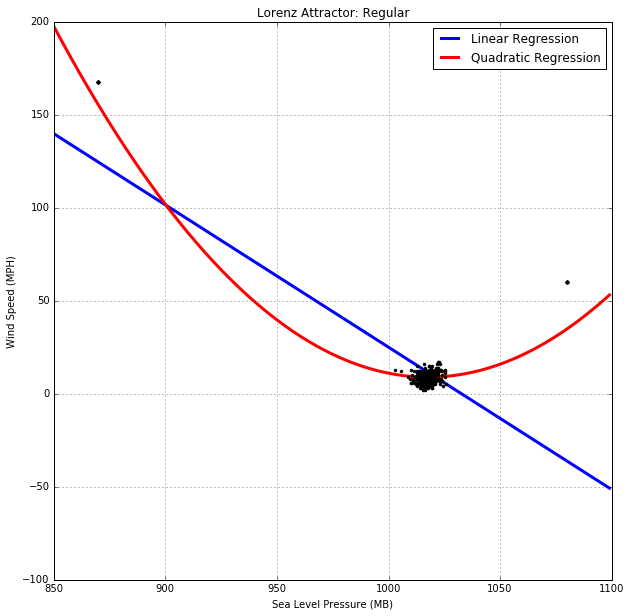

In [53]:
fig = plt.figure()
ax = fig.gca()

fig.set_figheight(10)
fig.set_figwidth(10)
        
# lines and points
ax.plot(plt_a, lin_regr.predict(plt_a.reshape(-1,1)), color='blue',linewidth=3)
ax.plot(plt_a, poly_regr.predict(plt_a.reshape(-1,1)), color='red',linewidth=3)
ax.plot(a,b,'.',color='black')

ax.set_xlabel("Sea Level Pressure (MB)")
ax.set_ylabel("Wind Speed (MPH)")
ax.set_title("Lorenz Attractor: Regular")

plt.xticks()
plt.yticks()
plt.grid()

plt.legend(["Linear Regression", "Quadratic Regression"])

plt.show()

As can be seen, a linear regression technique never had a chance at accurately modeling the data. Instead this polynomial techinque is able to better fit the data and give us the results we require.

### Getting Equation of the Line

The two options are:
1. Implement this in C#
2. Get equation of line and use it in C#

Option one, while interesting, is overkill for this problem as we have already built the model. Instead we can mark down the coefficients and intercept and simply implement the simple funciton. This reduces time spent on implementation and reduces computation required. Below is the formula for a quadratic line line of best fit.

$$
y = a_0 + a_1x + a_2x^2 + \epsilon
$$

In [54]:
def predict_wind_speed(presssure, coefficients=lasso.coef_, intercept=lasso.intercept_[0]):
    return coefficients[0] + coefficients[1]*presssure + coefficients[2]*(presssure**2) + intercept

In [55]:
x = 1000
predict_wind_speed(x)

11.080949977892487

In [56]:
poly_regr.predict(x)

array([ 11.08094998])

Where the variables are:

In [57]:
print "A0:       ", lasso.coef_[0]
print "A1:       ", lasso.coef_[1]
print "A2:       ", lasso.coef_[2]
print "Intercept:", lasso.intercept_

A0:        0.0
A1:        -13.6416172273
A2:        0.00670152751266
Intercept: [ 6951.17066465]


## Add Windspeed Vector to Data

In [58]:
def slope(coord1, coord2):
    return (coord2[1] - coord1[1]) / (coord2[0] - coord1[0])

In [59]:
def perpindicular_slope(s):
    if s == 0:
        return 0
    else:
        return -1/s

In [60]:
def get_wind_angle(p1, p2):
    ''' 
    return angle, in radians, between the two points.
    Please note the destinate coordinate should go into p1
    '''
    # get lengths of triangle legs
    adjacent = p2[1] - p1[1]
    opposite = p2[0] - p1[0]
    
    return math.atan2(opposite,adjacent)

In [61]:
def add_windspeed_vector(attractor_system, center, clock_wise):
    '''
    add temperature column to system
    
    Parameters:
        attractor_system - pressure system created in build_pressure_system
        center           - center of the lorenz pressure sysem
        clock_wise       - weather the sysem should move clockwise or not
    '''
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            # calculate wind speed
            wind_speed = predict_wind_speed(attractor_system[i]['data'][j]['pressure'])
            
            # get coordinates
            coordinates = attractor_system[i]['data'][j]['coord']
            
            # get slope of wind
            s = perpindicular_slope(slope(coordinates, center))
            
            # calculate y intercept
            y_intercept = coordinates[1] - (s*coordinates[0])
            
            # initialize coordinates
            x_coord = coordinates[0]
            y_coord = None
            
            # get x and y coords
            if center[1] == coordinates[1]:
                # get y coord based on direction of pressure system
                if center[0] >= coordinates[0]:
                    if clock_wise:
                        y = coordinates[1] + 1
                    else:
                        y = coordinates[1] - 1
                else:
                    if clock_wise:
                        y = coordinates[1] - 1
                    else:
                        y = coordinates[1] + 1
            else:
                # find x coord baed on direction of pressure system
                if center[1] > coordinates[1]:
                    if clock_wise:
                        x_coord += 1
                    else:
                        x_coord -= 1
                else:
                    if clock_wise:
                        x_coord -= 1
                    else:
                        x_coord += 1
                
                # calculate y_coord from x_coord
                y_coord = (s*x_coord) + y_intercept
            
            # get angle of vector
            angle = get_wind_angle((x_coord, y_coord),coordinates)
            
            # calculate force vector
            force = (wind_speed*math.cos(angle), wind_speed*math.sin(angle))

            # add magnitude, wind_speed variable
            attractor_system[i]['data'][j]['wind_speed'] = wind_speed
    
            # add force vector
            attractor_system[i]['data'][j]['wind_speed_force'] = force

In [62]:
def build_vectors(attractor_system):
    x = []
    y = []
    u = []
    v = []
    
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            x.append(attractor_system[i]['data'][j]['coord'][0])
            y.append(attractor_system[i]['data'][j]['coord'][1])
            u.append(attractor_system[i]['data'][j]['wind_speed_force'][0])
            v.append(attractor_system[i]['data'][j]['wind_speed_force'][1])
            
    return x,y,u,v

In [63]:
add_windspeed_vector(low_pressure_group, low_center, False)
add_windspeed_vector(high_pressure_group, high_center, True)

In [64]:
low_x, low_y, low_u, low_v     = build_vectors(low_pressure_group)
high_x, high_y, high_u, high_v = build_vectors(high_pressure_group)

In [65]:
q_x = low_x + high_x
q_y = low_y + high_y
q_u = low_u + high_u
q_v = low_v + high_v

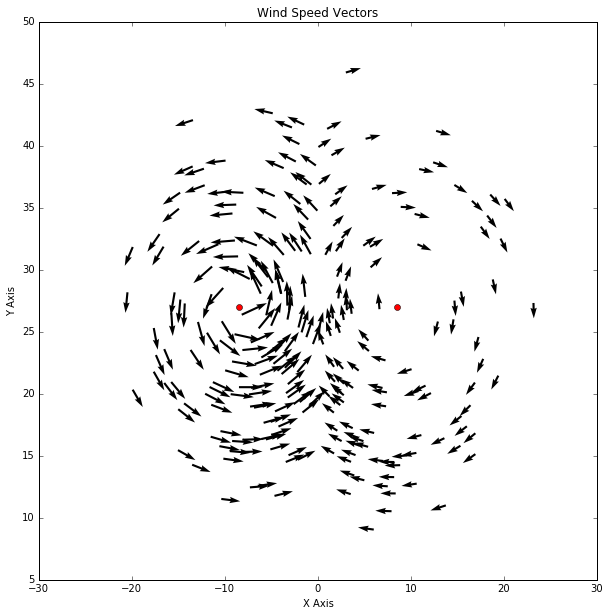

In [66]:
fig = plt.figure()
ax = fig.gca()

fig.set_figheight(10)
fig.set_figwidth(10)


ax.plot(y_center,z_center,'ro')
# Q = plt.quiver(q_x, q_y, q_u, q_v)
plt.quiver(q_x, q_y, q_v, q_u)

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")

plt.title('Wind Speed Vectors')

# Relative Humidity

In [67]:
mean_humidty_index            = 8 
mean_temperature_index        = 3
pressure_temperature_humidity = [[inch_to_mb(float(row[mean_pressure_index])), \
                                  float(row[mean_temperature_index]),\
                                  float(row[mean_humidty_index])] for row in rows]

In [68]:
a = np.array([(row[0], row[1]) for row in pressure_temperature_humidity])
b = np.array([row[2] for row in pressure_temperature_humidity])

In [69]:
a_shape = a.reshape(-1,2)
b_shape = b.reshape(-1,1)

# plotting points for 3d representation
plt_a        = range(850,1100)
plt_b        = range(0,100)
plt_humidity = []

# build humidty plot ranges
for pressure in plt_a:
    for temperature in plt_b:
        plt_humidity.append([pressure, temperature])

plt_humidity = np.array(plt_humidity)

# built a and b plots from combined from
plt_a = np.array([row[0] for row in plt_humidity])
plt_b = np.array([row[1] for row in plt_humidity])

In [70]:
# Create linear regression object
humid_linear_regression = linear_model.LinearRegression()

# Train the model using the training sets
humid_linear_regression.fit(a_shape, b_shape)

degree  = 2

# Create linear regression object
humid_poly  = PolynomialFeatures(degree)
humid_lasso = linear_model.Lasso()
humid_poly_regr = make_pipeline(humid_poly, humid_lasso)

# Train the model using the training sets
humid_poly_regr.fit(a_shape, b_shape)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [71]:
plt_lin_humidity = humid_linear_regression.predict(plt_humidity)
plt_pol_humidity = humid_poly_regr.predict(plt_humidity)

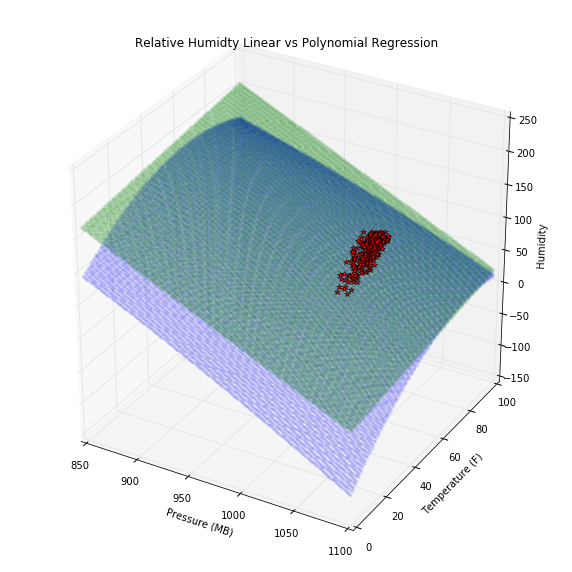

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)

# poly regression
pol_line = ax.plot(plt_a, plt_b, plt_pol_humidity,'b.', alpha=.1, label="Poly Regression")

# linear regression
lin_line = ax.plot(plt_a, plt_b, [row[0] for row in plt_lin_humidity],'g.',alpha=.1, label="Linear Regression")

# real world data
ax.plot([row[0] for row in pressure_temperature_humidity],\
        [row[1] for row in pressure_temperature_humidity],\
        [row[2] for row in pressure_temperature_humidity], 'r*')

ax.set_xlabel("Pressure (MB)")
ax.set_ylabel("Temperature (F)")
ax.set_zlabel("Humidity")
ax.set_title("Relative Humidty Linear vs Polynomial Regression")

The polynomial is at first unideal because it hits a humidity of -150 at the two extremes of 0 degree temperature and 1100 mb pressure. This, however, can be be prevented by setting a minimum of 0 for humidity. Similarly the same can be done with the maximum. WIth this in mind it can be seen that the the polynomial regression results in the most ideal behavior for the given data. Therefore in game this system will be taken advtange of. The coefficients for replicating the formula found with the polynomial regression is below.

In [73]:
print "coef_0:    ", humid_lasso.coef_[0],'\t\t', humid_poly.powers_[0]
print "coef_1:    ", humid_lasso.coef_[1],'\t\t', humid_poly.powers_[1]
print "coef_2:    ", humid_lasso.coef_[2],'\t\t', humid_poly.powers_[2]
print "coef_3:    ", humid_lasso.coef_[3],'\t',   humid_poly.powers_[3]
print "coef_4:    ", humid_lasso.coef_[4],'\t',   humid_poly.powers_[4]
print "coef_5:    ", humid_lasso.coef_[5],'\t',   humid_poly.powers_[5]
print "Intercept: ", humid_lasso.intercept_[0]

coef_0:     0.0 		[0 0]
coef_1:     0.0 		[1 0]
coef_2:     -0.0 		[0 1]
coef_3:     -0.000425689538738 	[2 0]
coef_4:     0.00282497331751 	[1 1]
coef_5:     -0.0184681159432 	[0 2]
Intercept:  402.687431384


$$
humidity = c_3p^2 + c_4pt + c_5t^2 + \epsilon
$$

In [74]:
def predict_relative_humidity(pressure, temperature):
    return humid_lasso.coef_[3]*(pressure**2) + \
           humid_lasso.coef_[4]*pressure*temperature + \
           humid_lasso.coef_[5]*(temperature**2) +\
           humid_lasso.intercept_[0]

In [75]:
pressure = 1000
temp     = 20

print humid_poly_regr.predict([(pressure, temp)])[0]
print predict_relative_humidity(pressure, temp)

26.1101126184
26.1101126184


In [76]:
def add_relative_humidity(attractor_system):
    '''
    add temperature column to system
    
    Parameters:
        attractor_system - pressure system created in build_pressure_system
        center           - center of the lorenz pressure sysem
        clock_wise       - weather the sysem should move clockwise or not
    '''
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            rh = predict_relative_humidity(attractor_system[i]['data'][j]['pressure'],
                                           attractor_system[i]['data'][j]['temp'])
            attractor_system[i]['data'][j]['relative_humidty'] = rh

In [77]:
add_relative_humidity(low_pressure_group)
add_relative_humidity(high_pressure_group)

# Relative Dew Point

In [78]:
def calculate_dew_point(T, RH):
    '''
    http://andrew.rsmas.miami.edu/bmcnoldy/Humidity.html
    temperature is in degrees
    '''
    T = float(T)
    RH = float(RH)
    return 243.04*(math.log(RH/100) + \
           ((17.625*T)/(243.04+T)))/(17.625-math.log(RH/100) - \
           ((17.625*T)/(243.04+T)))

In [79]:
def add_relative_dew_point(attractor_system):
    '''
    add temperature column to system
    
    Parameters:
        attractor_system - pressure system created in build_pressure_system
        center           - center of the lorenz pressure sysem
        clock_wise       - weather the sysem should move clockwise or not
    '''
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            dp = calculate_dew_point(attractor_system[i]['data'][j]['temp'],
                                     attractor_system[i]['data'][j]['relative_humidty'])
            attractor_system[i]['data'][j]['relative_dew_point'] = dp

In [80]:
add_relative_dew_point(low_pressure_group)
add_relative_dew_point(high_pressure_group)

# Precipitation

The machine learning for this will use the following parameters:
1. Pressure
2. Temperature
3. Humidity
4. Wind Magnitude
5. Dew Point

It will then produce the precipitaiton. Unfortunately, there isn't any way
to plot all six of these dimensions.

In [81]:
mean_humidty_index       = 8 
mean_temperature_index   = 3
mean_dew_point_index     = 6
mean_percipitation_index = 17
precipitation_data       = [[inch_to_mb(float(row[mean_pressure_index])), \
                           float(row[mean_temperature_index]),\
                           float(row[mean_humidty_index]),\
                           float(row[mean_wind_speed_index]),\
                           float(row[mean_dew_point_index]),\
                           float(row[mean_percipitation_index])] for row in rows]

In [82]:
a = np.array([(row[0], row[1], row[2], row[3], row[4]) for row in precipitation_data])
b = np.array([row[5] for row in precipitation_data])

In [84]:
a_shape = a.reshape(-1,5)
b_shape = b.reshape(-1,1)

In [92]:
# Create linear regression object
percip_linear_regression = linear_model.LinearRegression()

# Train the model using the training sets
percip_linear_regression.fit(a_shape, b_shape)

degree  = 2

# Create linear regression object
percip_poly  = PolynomialFeatures(degree)
percip_lasso = linear_model.Lasso()
percip_poly_regr = make_pipeline(percip_poly, percip_lasso)

# Train the model using the training sets
percip_poly_regr.fit(a_shape, b_shape)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [96]:
percip_poly.powers_

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [2, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 2, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 2, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 2]])

In [94]:
percip_lasso.coef_

array([  0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.46876693e-06,   2.07456756e-07,   1.50875127e-07,
         9.82522088e-04,  -3.10613821e-07,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00])